In [0]:
from google.colab import files
uploaded = files.upload()

Saving acs2017_census_tract_data.csv to acs2017_census_tract_data.csv


In [0]:
import pandas as pd
import numpy as np
from churn_analysis import *

In [0]:
county_census = pd.read_csv('acs2017_county_data.csv')

In [0]:
county_census.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [0]:
county_to_zip = pd.read_csv('COUNTY_ZIP_122017.csv')

In [0]:
county_to_zip.head()

,CountyId,Zipcode
0,1001,36006
1,1001,36703
2,1001,36749
3,1001,36068
4,1001,36701


In [0]:
len(county_census)

3220

In [0]:
nw_zipcode = pd.read_csv('northwestern_mutual_zipcode.csv')

In [0]:
nw_zipcode = (nw_zipcode.iloc[:,1])


In [0]:
nw_zipcode.head()

,Unnamed: 0,northwester_nmutual
0,0,11516.0
1,1,10022.0
2,2,23233.0
3,3,33487.0
4,4,91436.0


In [0]:
merge_nw_county = nw_zipcode.merge(county_to_zip, left_on = 'northwester_nmutual', right_on = 'Zipcode', how = 'left' )

In [0]:
len(np.unique(merge_nw_county.CountyId))

787

In [0]:
merged = county_census.merge(county_to_zip, on='CountyId')


In [0]:
merged.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Zipcode
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,36006
1,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,36703
2,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,36749
3,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,36068
4,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,36701


In [0]:
count = pd.DataFrame(merge_nw_county.CountyId.value_counts())

In [0]:
count = count.reset_index()

In [0]:
count = count.rename(columns={"index": "CountyId", "CountyId": "counts"})

In [0]:
count.head()

,CountyId,counts
0,36061.0,242
1,17031.0,220
2,6037.0,166
3,13121.0,144
4,48113.0,135


In [140]:
getDfSummary(count)

,mean,std,min,25%,50%,75%,max,missing,distinct
CountyId,30233.201560,15050.499352,1005.0,18107.0,29031.0,42083.0,56039.0,0.0,769.0
counts,11.962289,22.785969,1.0,1.0,3.0,14.0,242.0,0.0,79.0


In [0]:
merge_census_counts = county_census.merge(count, on = 'CountyId', how = 'left')

In [0]:
merge_census_counts.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,counts
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,NaN
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5,NaN
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4,1.0
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2,NaN
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9,NaN


In [0]:
merge_census_counts = merge_census_counts.fillna(0)

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [97]:
X_model = merge_census_counts.iloc[:,3:-1]
Y_model = merge_census_counts['counts']
print(X_model.head())
Y_model.head()

   TotalPop    Men   Women  ...  SelfEmployed  FamilyWork  Unemployment
0     55036  26899   28137  ...           5.6         0.1           5.2
1    203360  99527  103833  ...           6.3         0.1           5.5
2     26201  13976   12225  ...           6.5         0.3          12.4
3     22580  12251   10329  ...           6.3         0.3           8.2
4     57667  28490   29177  ...           4.0         0.1           4.9

[5 rows x 34 columns]


0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: counts, dtype: float64

In [109]:
rows = np.random.choice(merge_census_counts[merge_census_counts.counts==0].index, 300)
prediction_df = merge_census_counts.ix[rows]

(300, 38)

In [0]:
new_rows = set(merge_census_counts.index) - set(rows)
train_val_test = merge_census_counts.ix[new_rows]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_val_test.drop(['counts','CountyId','State','County'],axis = 1),train_val_test['counts'],test_size= 0.1)




In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size= 0.3)

In [139]:
from sklearn.metrics import mean_squared_error
alphas = np.linspace(0, 1, num=5)
for alpha in alphas:
  reg = linear_model.Lasso(alpha = alpha)
  reg.fit(X_train, y_train)
  predictions = reg.predict(X_val)
  val_error = mean_squared_error(predictions,y_val)
  print(alpha)
  print(val_error)
  print('-' *10)

0.0
47.05640536280262
----------
0.25
46.536004779034016
----------
0.5
46.33175784355603
----------
0.75
46.280716937884335
----------
1.0
46.36410093748434
----------


In [189]:
mean_squared_error(predictions,y_val)
from sklearn.metrics import mean_squared_error
alphas = np.linspace(0.5, 0.75, num=5)
for alpha in alphas:
  reg = linear_model.Lasso(alpha = alpha)
  reg.fit(X_train, y_train)
  predictions = list(map(lambda x:int(x),reg.predict(X_val)))
  predictions = [x if x>0 else 0 for x in predictions]
  val_error = mean_squared_error(predictions,y_val)
  print(alpha)
  print(val_error)
  print('-' *10)

0.5
42.31612090680101
----------
0.5625
42.503778337531486
----------
0.625
42.53400503778337
----------
0.6875
42.455919395466
----------
0.75
42.47858942065491
----------


In [0]:
reg = linear_model.Lasso(alpha = 0.75)
reg.fit(X_train, y_train)
#prediction_df.iloc[reg.predict(X_test).argsort()[-10:][::-1],].IncomePerCap
reg.predict(X_test)

In [0]:
coef_linear = pd.DataFrame(reg.coef_)
col_name = pd.DataFrame(X_train.columns)
cat = pd.concat([col_name, coef_linear], axis = 1)

In [192]:
cat

,0,0
0,TotalPop,-0.000242
1,Men,-0.000085
2,Women,0.000160
3,Hispanic,0.007375
4,White,-0.036917
5,Black,0.000000
6,Native,0.000649
7,Asian,-0.247759
8,Pacific,-0.000000
9,VotingAgeCitizen,0.000124


In [188]:
getDfSummary(pd.DataFrame(list(map(lambda x:int(x),reg.predict(X_test)))))

,mean,std,min,25%,50%,75%,max,missing,distinct
0,2.343537,6.774854,-8.0,0.0,0.0,2.0,60.0,0.0,31.0


In [149]:

from xgboost import XGBClassifier
dtrain = xgb.DMatrix(X_train,label = y_train)

num_round = 10
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [148]:
predictions = model.predict(X_val)
mean_squared_error(predictions,y_val)

80.58564231738035

In [153]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

AttributeError: ignored

In [157]:
model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
model.fit(X_train, y_train)
predictions = model.predict(X_val)
mean_squared_error(predictions,y_val)

70.11083123425692

In [0]:
coef_linear = pd.DataFrame(reg.coef_)
col_name = pd.DataFrame(X.columns)
cat = pd.concat([col_name, coef_linear], axis = 1)

In [0]:
cat = pd.concat([col_name, coef_linear], axis = 1)

In [0]:
cat


In [0]:
import statsmodels.api as sm
from scipy import stats


In [0]:
est = sm.OLS(Y,X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                 counts   R-squared (uncentered):                   0.651
Model:                            OLS   Adj. R-squared (uncentered):              0.647
Method:                 Least Squares   F-statistic:                              180.1
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                        0.00
Time:                        18:23:27   Log-Likelihood:                         -11025.
No. Observations:                3220   AIC:                                  2.212e+04
Df Residuals:                    3187   BIC:                                  2.232e+04
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [0]:
X.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [0]:
X = X.drop(['SelfEmployed','TotalPop','Hispanic','SelfEmployed'], axis = 1)
X.head()

,Men,Women,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,FamilyWork,Unemployment
0,26899,28137,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,0.1,5.2
1,99527,103833,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,0.1,5.5
2,13976,12225,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,0.3,12.4
3,12251,10329,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,0.3,8.2
4,28490,29177,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,0.1,4.9


In [0]:
X = X.drop(['SelfEmployed','TotalPop','Hispanic','SelfEmployed'], axis = 1)
X.head()

In [0]:
X = X.drop(['VotingAgeCitizen'], axis = 1)
X.head()

,Men,Women,White,Black,Native,Asian,Pacific,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,FamilyWork,Unemployment
0,26899,28137,75.4,18.9,0.3,0.9,0.0,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,0.1,5.2
1,99527,103833,83.1,9.5,0.8,0.7,0.0,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,0.1,5.5
2,13976,12225,45.7,47.8,0.2,0.6,0.0,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,0.3,12.4
3,12251,10329,74.6,22.0,0.4,0.0,0.0,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,0.3,8.2
4,28490,29177,87.4,1.5,0.3,0.1,0.0,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,0.1,4.9


In [0]:
est_ = sm.OLS(Y,X)
est2_ = est_.fit()
print(est2_.summary())

                                 OLS Regression Results                                
Dep. Variable:                 counts   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              182.6
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:26:01   Log-Likelihood:                         -11111.
No. Observations:                3220   AIC:                                  2.228e+04
Df Residuals:                    3190   BIC:                                  2.246e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [0]:
getDfSummary(X)

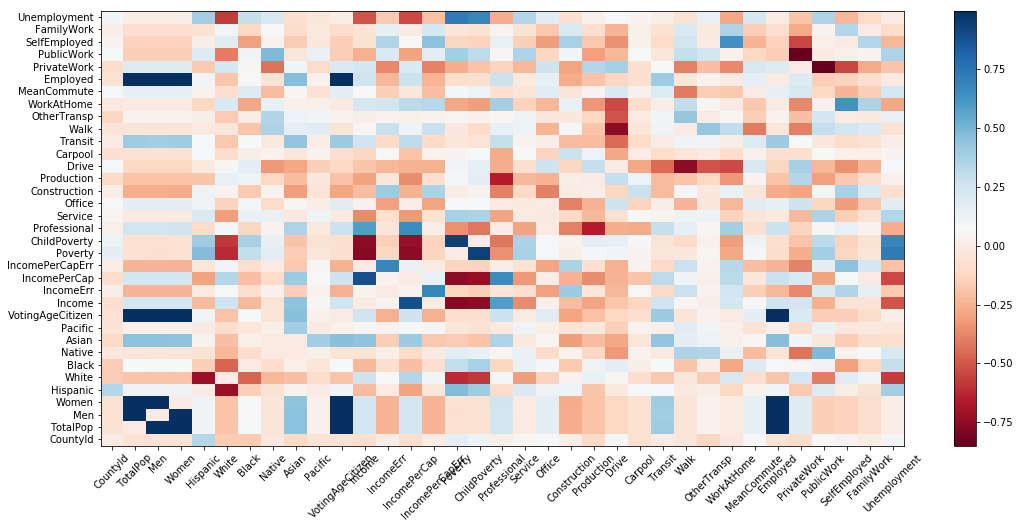

In [0]:
plotCorr(merge_census_counts ,'counts',18,8)

In [0]:
list(merge_census_counts.counts).count(0)

2451

In [0]:
len(merge_census_counts.counts)

3220

In [0]:
len(np.unique(merge_census_counts.CountyId))

3220

In [0]:
#import pandas as pd
from sklearn import preprocessing

#x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.values)
X_scaled = pd.DataFrame(x_scaled, columns = X.columns)

In [0]:
X_scaled.head()

,Men,Women,White,Black,Native,Asian,Pacific,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,FamilyWork,Unemployment
0,0.005394,0.005482,0.754,0.217491,0.003322,0.021531,0.0,0.370094,0.063232,0.344117,0.118319,0.179936,0.240431,0.414931,0.387931,0.567901,0.222527,0.316222,0.879050,0.327645,0.001618,0.010135,0.030093,0.075758,0.5175,0.005009,0.745234,0.261589,0.0125,0.127139
1,0.019979,0.020249,0.831,0.109321,0.008859,0.016746,0.0,0.346728,0.026658,0.368336,0.037837,0.149682,0.192584,0.421875,0.392241,0.641975,0.266484,0.221766,0.865011,0.259386,0.001618,0.013514,0.025463,0.169697,0.5475,0.018621,0.859619,0.140728,0.0125,0.134474
2,0.002799,0.002378,0.457,0.550058,0.002215,0.014354,0.0,0.183940,0.056187,0.182713,0.041771,0.394904,0.537081,0.236111,0.362069,0.549383,0.315934,0.494867,0.850972,0.378840,0.004854,0.037162,0.039352,0.039394,0.4575,0.001839,0.745234,0.243377,0.0375,0.303178
3,0.002452,0.002008,0.746,0.253165,0.004430,0.000000,0.0,0.269057,0.077788,0.235398,0.109890,0.203822,0.318182,0.225694,0.379310,0.459877,0.436813,0.459959,0.883369,0.324232,0.011327,0.005068,0.039352,0.045455,0.6225,0.001692,0.778163,0.215232,0.0375,0.200489
4,0.005714,0.005685,0.874,0.017261,0.003322,0.002392,0.0,0.303050,0.058126,0.252854,0.045017,0.210191,0.303828,0.296875,0.278017,0.570988,0.434066,0.400411,0.887689,0.348123,0.001618,0.006757,0.009259,0.063636,0.7475,0.004441,0.915078,0.124172,0.0125,0.119804


In [0]:
getDfSummary(X)

,mean,std,min,25%,50%,75%,max,missing,distinct
Men,49587.810559,159321.182902,39.0,5645.500,12879.0,33017.250,4979641.0,0.0,3112.0
Women,51180.316770,165216.389158,35.0,5553.500,12993.5,33593.750,5126081.0,0.0,3087.0
White,74.920186,23.056700,0.0,63.500,83.6,92.800,100.0,0.0,728.0
Black,8.681957,14.333571,0.0,0.600,2.0,9.500,86.9,0.0,487.0
Native,1.768416,7.422946,0.0,0.100,0.3,0.600,90.3,0.0,184.0
Asian,1.289379,2.716191,0.0,0.200,0.6,1.200,41.8,0.0,130.0
Pacific,0.083416,0.709277,0.0,0.000,0.0,0.100,33.7,0.0,28.0
Income,48994.966770,13877.178398,11680.0,40622.000,47636.5,55476.000,129588.0,0.0,3074.0
IncomeErr,3138.616770,2405.786950,262.0,1729.750,2587.0,3802.000,41001.0,0.0,2399.0
IncomePerCap,25657.033230,6667.520452,5943.0,21568.000,25139.0,28997.000,69529.0,0.0,2982.0


In [0]:
getDfSummary(X_scaled)

,mean,std,min,25%,50%,75%,max,missing,distinct
Men,0.009950,0.031995,0.0,0.001126,0.002579,0.006623,1.0,0.0,3112.0
Women,0.009978,0.032231,0.0,0.001077,0.002528,0.006547,1.0,0.0,3087.0
White,0.749202,0.230567,0.0,0.635000,0.836000,0.928000,1.0,0.0,728.0
Black,0.099907,0.164943,0.0,0.006904,0.023015,0.109321,1.0,0.0,487.0
Native,0.019584,0.082203,0.0,0.001107,0.003322,0.006645,1.0,0.0,184.0
Asian,0.030846,0.064981,0.0,0.004785,0.014354,0.028708,1.0,0.0,130.0
Pacific,0.002475,0.021047,0.0,0.000000,0.000000,0.002967,1.0,0.0,28.0
Income,0.316475,0.117695,0.0,0.245463,0.304954,0.371442,1.0,0.0,3074.0
IncomeErr,0.070611,0.059054,0.0,0.036028,0.057071,0.086895,1.0,0.0,2399.0
IncomePerCap,0.310037,0.104858,0.0,0.245730,0.301890,0.362564,1.0,0.0,2982.0


In [0]:
est_ = sm.OLS(Y,X_scaled)
est2_ = est_.fit()
print(est2_.summary())

                                 OLS Regression Results                                
Dep. Variable:                 counts   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.629
Method:                 Least Squares   F-statistic:                              182.6
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:33:18   Log-Likelihood:                         -11111.
No. Observations:                3220   AIC:                                  2.228e+04
Df Residuals:                    3190   BIC:                                  2.246e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

#hide hide